In [2]:
# Import Libraries
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate, UpSampling1D, LeakyReLU, Conv1D, BatchNormalization, LayerNormalization, Flatten, Reshape, LSTM, Bidirectional, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def load_opcodes(folder_path, sequence_length=1000):
    """Load opcode files and ensure each sample has exactly sequence_length opcodes."""
    opcode_sequences = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as f:
            opcodes = [line.strip() for line in f if line.strip()]
        # Ensure exactly sequence_length opcodes
        if len(opcodes) >= sequence_length:
            opcodes = opcodes[:sequence_length]
        else:
            continue  # Skip files with insufficient opcodes
        opcode_sequences.append(opcodes)
    print(f"Loaded {len(opcode_sequences)} valid samples")
    return opcode_sequences

def create_opcode_dictionary(opcode_sequences, top_n=40):
    """Create a dictionary of the top N most frequent opcodes."""
    all_opcodes = [opcode for sequence in opcode_sequences for opcode in sequence]
    opcode_counts = Counter(all_opcodes)
    top_opcodes = [opcode for opcode, _ in opcode_counts.most_common(top_n)]
    opcode_dict = {opcode: idx for idx, opcode in enumerate(top_opcodes)}  # 0 to N-1
    print(f"Created dictionary with {len(opcode_dict)} opcodes")
    return opcode_dict

def map_opcodes(opcode_sequences, opcode_dict, sequence_length=1000):
    """Map opcodes to integer representations."""
    n_plus_one = len(opcode_dict)  # For unknown opcodes
    mapped_sequences = []
    for sequence in opcode_sequences:
        mapped = [opcode_dict.get(opcode, n_plus_one) for opcode in sequence]
        mapped_sequences.append(mapped)
    return np.array(mapped_sequences)

# Load and preprocess data
folder_path = 'opcodes'
sequence_length = 1000
opcode_sequences = load_opcodes(folder_path, sequence_length)
opcode_dict = create_opcode_dictionary(opcode_sequences, top_n=40)
data = map_opcodes(opcode_sequences, opcode_dict, sequence_length)

# Normalize data to [0, 1] for model input
unique_opcodes = len(opcode_dict)  # Including N+1
data_normalized = data / unique_opcodes

# Validate data shape
print(f"Data shape: {data.shape}, Normalized data shape: {data_normalized.shape}")
if data_normalized.ndim != 2 or data_normalized.shape[1] != 1000:
    raise ValueError(f"Expected data_normalized to have shape (n_samples, 1000), got {data_normalized.shape}")
data_normalized = data_normalized.reshape(-1, 1000, 1)
print(f"Reshaped data_normalized shape: {data_normalized.shape}")

Loaded 4876 valid samples
Created dictionary with 40 opcodes
Data shape: (4876, 1000), Normalized data shape: (4876, 1000)
Reshaped data_normalized shape: (4876, 1000, 1)


In [4]:
class WGAN_GP:
    def __init__(self, input_shape=(1000, 1), latent_dim=100, unique_opcodes=40):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.unique_opcodes = unique_opcodes
        self.lambda_gp = 10
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        self.critic_losses = []
        self.generator_losses = []
        self.svm_accuracy = []

    def build_generator(self):
        model = Sequential([
            Dense(128 * 150, input_dim=self.latent_dim),
            Reshape((150, 128)),
            Conv1D(128, kernel_size=5, padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv1D(64, kernel_size=5, padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv1D(32, kernel_size=5, padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Flatten(),
            Dense(np.prod(self.input_shape)),
            Reshape(self.input_shape)
        ], name='generator')
        return model

    def build_critic(self):
        model = Sequential([
            Conv1D(32, kernel_size=5, strides=2, padding='same', input_shape=self.input_shape),
            LeakyReLU(alpha=0.2),
            Conv1D(64, kernel_size=5, strides=2, padding='same'),
            LeakyReLU(alpha=0.2),
            Conv1D(128, kernel_size=5, strides=2, padding='same'),
            LeakyReLU(alpha=0.2),
            Flatten(),
            Dense(1)
        ], name='critic')
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-10)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train(self, data, data_bef_norm, epochs=10000, batch_size=64, n_critic=5):
        critic_optimizer = Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9, clipnorm=1.0)
        generator_optimizer = Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9, clipnorm=1.0)

        if data.shape[1:] != self.input_shape:
            raise ValueError(f"Data shape {data.shape[1:]} does not match input_shape {self.input_shape}")

        for epoch in range(epochs):
            for _ in range(n_critic):
                idx = np.random.randint(0, data.shape[0], batch_size)
                real_samples = data[idx].astype(np.float32)
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim)).astype(np.float32)
                fake_samples = self.generator(noise, training=True)

                with tf.GradientTape() as tape:
                    real_output = self.critic(real_samples, training=True)
                    fake_output = self.critic(fake_samples, training=True)
                    gp = self.gradient_penalty(real_samples, fake_samples)
                    critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + self.lambda_gp * gp

                grads = tape.gradient(critic_loss, self.critic.trainable_variables)
                if not grads or any(g is None for g in grads):
                    print(f"Epoch {epoch}: Warning: No gradients for critic. Loss: {critic_loss.numpy()}")
                    continue
                critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
                self.critic_losses.append(critic_loss.numpy())

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim)).astype(np.float32)
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                fake_output = self.critic(fake_samples, training=True)
                gen_loss = -tf.reduce_mean(fake_output)

            grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            if not grads or any(g is None for g in grads):
                print(f"Epoch {epoch}: Warning: No gradients for generator. Loss: {gen_loss.numpy()}")
                continue
            generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
            self.generator_losses.append(gen_loss.numpy())

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Critic Loss: {critic_loss.numpy():.4f}, Generator Loss: {gen_loss.numpy():.4f}, GP: {gp.numpy():.4f}")
                synthetic_samples = self.generate_samples(100)
                X = np.vstack([data_bef_norm[:100], synthetic_samples])
                y = np.hstack([np.ones(100), np.zeros(100)])
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y
                )
                clf = SVC(C=5, kernel='rbf')
                clf.fit(X_train, y_train)
                test_accuracy = accuracy_score(y_test, clf.predict(X_test))
                self.svm_accuracy.append(test_accuracy)
                print(f"Epoch {epoch}, SVM Test Accuracy: {test_accuracy:.40f}")

    def generate_samples(self, n_samples):
        noise = np.random.normal(0, 1, (n_samples, self.latent_dim)).astype(np.float32)
        samples = self.generator(noise, training=False)
        samples = samples * self.unique_opcodes
        samples = np.round(samples.numpy()).astype(int)
        samples = np.clip(samples, 0, self.unique_opcodes)
        return samples.reshape(n_samples, 1000)

# Initialize and train WGAN-GP
wgan = WGAN_GP()
wgan.train(data_normalized, data, epochs=600, batch_size=32, n_critic=15)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0, Critic Loss: 8.2387, Generator Loss: 0.0593, GP: 0.8292
Epoch 0, SVM Test Accuracy: 1.0000000000000000000000000000000000000000
Epoch 10, Critic Loss: 6.1835, Generator Loss: 0.9900, GP: 0.7010
Epoch 10, SVM Test Accuracy: 1.0000000000000000000000000000000000000000
Epoch 20, Critic Loss: 1.5545, Generator Loss: 3.2969, GP: 0.4311
Epoch 20, SVM Test Accuracy: 1.0000000000000000000000000000000000000000
Epoch 30, Critic Loss: -5.5272, Generator Loss: 9.6303, GP: 0.0860
Epoch 30, SVM Test Accuracy: 1.0000000000000000000000000000000000000000
Epoch 40, Critic Loss: -17.9338, Generator Loss: 30.3118, GP: 0.0223
Epoch 40, SVM Test Accuracy: 0.9250000000000000444089209850062616169453
Epoch 50, Critic Loss: -22.5619, Generator Loss: 51.4288, GP: 0.7414
Epoch 50, SVM Test Accuracy: 0.8249999999999999555910790149937383830547
Epoch 60, Critic Loss: -22.2619, Generator Loss: 45.8359, GP: 0.6558
Epoch 60, SVM Test Accuracy: 0.8249999999999999555910790149937383830547
Epoch 70, Critic Loss: -18

In [5]:
from keras import ops as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.models import Model
import numpy as np

class SamplingLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim   = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        # compute per-sample KL divergence, then average
        kl = -0.5 * tf.reduce_sum(
            1 + z_log_var
              - tf.square(z_mean)
              - tf.exp(z_log_var),
            axis=-1
        )               # shape=(batch,)
        self.add_loss(tf.reduce_mean(kl))
        return z

class DenseVAE:
    def __init__(self, input_dim=1000, latent_dim=2):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()
        self.z_samples = []

    def build_encoder(self):
        inputs = tf.keras.Input(shape=(self.input_dim,))
        x = Dense(256, activation='relu')(inputs)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        z = SamplingLayer()([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name='encoder')

    def build_decoder(self):
        inputs = tf.keras.Input(shape=(self.latent_dim,))
        x = Dense(16, activation='relu')(inputs)
        x = Dense(32, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(self.input_dim, activation='sigmoid')(x)
        return Model(inputs, outputs, name='decoder')

    def build_vae(self):
        inputs = Input(shape=(self.input_dim,))
        _, _, z = self.encoder(inputs)
        outputs = self.decoder(z)
        vae = Model(inputs, outputs, name="vae")

        # only reconstruction loss here – KL is already in model.losses
        def recon_loss(y_true, y_pred):
            bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
            return tf.reduce_sum(bce, axis=-1)

        vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss=recon_loss)
        return vae

    def train(self, data, epochs=100, batch_size=64):
        history = self.vae.fit(data, data, epochs=epochs, batch_size=batch_size, verbose=1)
        z_mean, _, _ = self.encoder.predict(data, verbose=0)
        self.z_samples = z_mean
        return history

    def generate_samples(self, n_samples, unique_opcodes):
        z_sample = np.random.normal(0, 1, (n_samples, self.latent_dim)).astype(np.float32)
        samples = self.decoder.predict(z_sample, verbose=0)
        samples = samples * unique_opcodes
        samples = np.round(samples).astype(int)
        samples = np.clip(samples, 0, unique_opcodes)
        return samples

# Initialize and train Dense VAE
vae = DenseVAE()
vae_history = vae.train(data_normalized, epochs=100, batch_size=64)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 40.6476
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 37.0648
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.8728
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.8069
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.6861
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.5178
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.3729
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.2647
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36.2707
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36.0476
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.1085
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.9994
Epoch 13/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1372
Epoch 14/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.0681
Epoch 15/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

Created 5 clusters for conditioning


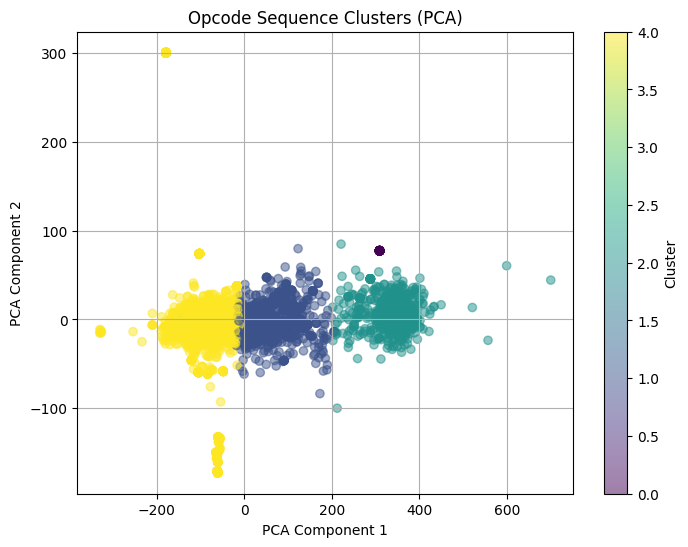

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Create pseudo-labels using K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_labels = kmeans.fit_predict(data)  # Shape: (4876,)
print(f"Created {n_clusters} clusters for conditioning")

# Visualize clusters using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=pseudo_labels, cmap='viridis', alpha=0.5)
plt.title('Opcode Sequence Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [7]:
class CGAN:
    def __init__(self, input_shape=(1000, 1), latent_dim=100, unique_opcodes=40, n_classes=5):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.unique_opcodes = unique_opcodes
        self.n_classes = n_classes
        self.lambda_gp = 10
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        self.critic_losses = []
        self.generator_losses = []

    def build_generator(self):
        noise_input = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(self.n_classes,))
        x = Concatenate()([noise_input, label_input])
        x = Dense(128 * 150)(x)
        x = Reshape((150, 128))(x)
        x = Conv1D(128, kernel_size=5, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Conv1D(64, kernel_size=5, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Conv1D(32, kernel_size=5, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Flatten()(x)
        x = Dense(np.prod(self.input_shape))(x)
        outputs = Reshape(self.input_shape)(x)
        return Model([noise_input, label_input], outputs, name='generator')

    def build_critic(self):
        data_input = Input(shape=self.input_shape)
        label_input = Input(shape=(self.n_classes,))
        x = Conv1D(32, kernel_size=5, strides=2, padding='same')(data_input)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Conv1D(64, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Conv1D(128, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(negative_slope=0.2)(x)
        x = Flatten()(x)
        x = Concatenate()([x, label_input])
        outputs = Dense(1)(x)
        return Model([data_input, label_input], outputs, name='critic')

    def gradient_penalty(self, real_samples, fake_samples, labels):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic([interpolated, labels], training=True)
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-10)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train(self, data, data_bef_norm, labels, epochs=600, batch_size=32, n_critic=15):
        critic_optimizer = Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9, clipnorm=1.0)
        generator_optimizer = Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9, clipnorm=1.0)
        one_hot_labels = tf.convert_to_tensor(tf.keras.utils.to_categorical(labels, num_classes=self.n_classes), dtype=tf.float32)

        if data.shape[1:] != self.input_shape:
            raise ValueError(f"Data shape {data.shape[1:]} does not match input_shape {self.input_shape}")

        for epoch in range(epochs):
            for _ in range(n_critic):
                idx = np.random.randint(0, data.shape[0], batch_size)
                idx_tensor = tf.convert_to_tensor(idx, dtype=tf.int64)
                real_samples = tf.convert_to_tensor(data[idx], dtype=tf.float32)  # Convert to tensor
                batch_labels = tf.gather(one_hot_labels, idx_tensor)
                noise = tf.convert_to_tensor(np.random.normal(0, 1, (batch_size, self.latent_dim)), dtype=tf.float32)  # Convert to tensor
                fake_samples = self.generator([noise, batch_labels], training=True)

                with tf.GradientTape() as tape:
                    real_output = self.critic([real_samples, batch_labels], training=True)
                    fake_output = self.critic([fake_samples, batch_labels], training=True)
                    gp = self.gradient_penalty(real_samples, fake_samples, batch_labels)
                    critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + self.lambda_gp * gp

                grads = tape.gradient(critic_loss, self.critic.trainable_variables)
                if not grads or any(g is None for g in grads):
                    print(f"Epoch {epoch}: Warning: No gradients for critic. Loss: {critic_loss.numpy()}")
                    continue
                critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
                self.critic_losses.append(critic_loss.numpy())

            noise = tf.convert_to_tensor(np.random.normal(0, 1, (batch_size, self.latent_dim)), dtype=tf.float32)  # Convert to tensor
            idx = np.random.randint(0, data.shape[0], batch_size)
            idx_tensor = tf.convert_to_tensor(idx, dtype=tf.int64)
            batch_labels = tf.gather(one_hot_labels, idx_tensor)
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, batch_labels], training=True)
                fake_output = self.critic([fake_samples, batch_labels], training=True)
                gen_loss = -tf.reduce_mean(fake_output)

            grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            if not grads or any(g is None for g in grads):
                print(f"Epoch {epoch}: Warning: No gradients for generator. Loss: {gen_loss.numpy()}")
                continue
            generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
            self.generator_losses.append(gen_loss.numpy())

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Critic Loss: {critic_loss.numpy():.4f}, Generator Loss: {gen_loss.numpy():.4f}, GP: {gp.numpy():.4f}")
                synthetic_samples = self.generate_samples(100, pseudo_labels[:100])
                X = np.vstack([data_bef_norm[:100], synthetic_samples])
                y = np.hstack([np.ones(100), np.zeros(100)])
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y
                )
                clf = SVC(C=5, kernel='rbf')
                clf.fit(X_train, y_train)
                test_accuracy = accuracy_score(y_test, clf.predict(X_test))
                print(f"Epoch {epoch}, SVM Test Accuracy: {test_accuracy:.4f}")

    def generate_samples(self, n_samples, labels):
        noise = np.random.normal(0, 1, (n_samples, self.latent_dim)).astype(np.float32)
        one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=self.n_classes)
        samples = self.generator([noise, one_hot_labels], training=False)
        samples = samples * self.unique_opcodes
        samples = np.round(samples.numpy()).astype(int)
        samples = np.clip(samples, 0, self.unique_opcodes)
        return samples.reshape(n_samples, 1000)

# Initialize and train CGAN
cgan = CGAN(n_classes=n_clusters)
cgan.train(data_normalized, data, pseudo_labels, epochs=600, batch_size=32, n_critic=15)

Epoch 0, Critic Loss: 8.3124, Generator Loss: 0.0922, GP: 0.8395
Epoch 0, SVM Test Accuracy: 1.0000
Epoch 10, Critic Loss: 6.0061, Generator Loss: 1.1711, GP: 0.7067
Epoch 10, SVM Test Accuracy: 1.0000
Epoch 20, Critic Loss: 0.6812, Generator Loss: 3.4736, GP: 0.3789
Epoch 20, SVM Test Accuracy: 1.0000
Epoch 30, Critic Loss: -6.7264, Generator Loss: 10.3856, GP: 0.0574
Epoch 30, SVM Test Accuracy: 1.0000
Epoch 40, Critic Loss: -20.6349, Generator Loss: 32.8117, GP: 0.0485
Epoch 40, SVM Test Accuracy: 0.9000
Epoch 50, Critic Loss: -25.2589, Generator Loss: 52.1201, GP: 0.7456
Epoch 50, SVM Test Accuracy: 0.8250
Epoch 60, Critic Loss: -20.4360, Generator Loss: 45.0631, GP: 0.5635
Epoch 60, SVM Test Accuracy: 0.8250
Epoch 70, Critic Loss: -18.7340, Generator Loss: 42.3395, GP: 0.5428
Epoch 70, SVM Test Accuracy: 0.8250
Epoch 80, Critic Loss: -18.8143, Generator Loss: 40.8220, GP: 0.4832
Epoch 80, SVM Test Accuracy: 0.8000
Epoch 90, Critic Loss: -19.0721, Generator Loss: 39.1122, GP: 0.454

In [8]:
# Generate synthetic samples
n_samples = len(data)
synthetic_wgan = wgan.generate_samples(n_samples)
synthetic_vae = vae.generate_samples(n_samples, 40)
synthetic_cgan_labels = np.random.randint(0, n_clusters, n_samples)  # Randomly assign cluster labels
synthetic_cgan = cgan.generate_samples(n_samples, synthetic_cgan_labels)
print(f"Generated {n_samples} synthetic samples for WGAN-GP, Dense VAE, and CGAN")

Generated 4876 synthetic samples for WGAN-GP, Dense VAE, and CGAN


In [35]:
def build_lstm_classifier(input_dim, vocab_size=41):
    model = Sequential([
        Embedding(vocab_size, 32, input_length=input_dim),
        LSTM(100, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm_classifier(input_dim, vocab_size=41):
    model = Sequential([
        Embedding(vocab_size, 32, input_length=input_dim),
        Dropout(0.2),
        Bidirectional(LSTM(100)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm_classifier(input_dim, vocab_size=41):
    model = Sequential([
        Embedding(vocab_size, 32, input_length=input_dim),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_classifiers(real_data, synthetic_data, input_dim=1000):
    """Evaluate classifiers with 5-fold cross-validation."""
    X = np.vstack([real_data, synthetic_data])
    y = np.hstack([np.ones(len(real_data)), np.zeros(len(synthetic_data))])

    classifiers = {
        'SVM': SVC(C=5, kernel='rbf'),
        'RF': RandomForestClassifier(n_estimators=50, max_depth=5),
        'KNN': KNeighborsClassifier(n_neighbors=1, p=2),
        'LSTM': build_lstm_classifier(input_dim),
        'BiLSTM': build_bilstm_classifier(input_dim),
        'CNN-LSTM': build_cnn_lstm_classifier(input_dim)
    }

    results = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        precision, recall, accuracy = [], [], []
        for train_idx, test_idx in kf.split(X):
            print(name)
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            if 'LSTM' in name:
                early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, restore_best_weights=True)
                clf.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0, callbacks=[early_stopping])
                y_pred = (clf.predict(X_test, verbose=0) > 0.5).astype(int)
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

            precision.append(precision_score(y_test, y_pred))
            recall.append(recall_score(y_test, y_pred))
            accuracy.append(accuracy_score(y_test, y_pred))

        results[name] = {
            'Precision': np.mean(precision),
            'Recall': np.mean(recall),
            'Accuracy': np.mean(accuracy)
        }

    return results

def find_min_samples(real_data, synthetic_data, target_accuracy=0.95):
    """Find minimum samples for 95% accuracy using binary search."""
    X = np.vstack([real_data, synthetic_data])
    y = np.hstack([np.ones(len(real_data)), np.zeros(len(synthetic_data))])

    classifiers = {
        'SVM': SVC(C=5, kernel='rbf'),
        'RF': RandomForestClassifier(n_estimators=50, max_depth=5),
        'KNN': KNeighborsClassifier(n_neighbors=1, p=2),
        'LSTM': build_lstm_classifier(1000),
        'BiLSTM': build_bilstm_classifier(1000),
        'CNN-LSTM': build_cnn_lstm_classifier(1000)
    }

    min_samples = {}
    max_samples = len(X) // 2

    for name, clf in classifiers.items():
        print(name)
        left, right = 10, max_samples
        best_samples = max_samples

        while left <= right:
            mid = (left + right) // 2
            idx = np.random.permutation(len(X))[:mid*2]
            X_subset = X[idx]
            y_subset = y[idx]
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

            if 'LSTM' in name:
                early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, restore_best_weights=True)
                clf.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0, callbacks=[early_stopping])
                y_pred = (clf.predict(X_test, verbose=0) > 0.5).astype(int)
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            if acc >= target_accuracy:
                best_samples = mid
                right = mid - 1
            else:
                left = mid + 1

        min_samples[name] = best_samples * 2  # Total samples (real + synthetic)

    return min_samples

# Evaluate WGAN-GP
print("Evaluating WGAN-GP Synthetic Malware")
wgan_results = evaluate_classifiers(data, synthetic_wgan)
print("WGAN-GP Classification Results:")
for clf, metrics in wgan_results.items():
    print(f"{clf}: Precision={metrics['Precision']:.2f}, Recall={metrics['Recall']:.2f}, Accuracy={metrics['Accuracy']:.2f}")

# Evaluate Dense VAE
print("\nEvaluating Dense VAE Synthetic Malware")
vae_results = evaluate_classifiers(data, synthetic_vae)
print("Dense VAE Classification Results:")
for clf, metrics in vae_results.items():
    print(f"{clf}: Precision={metrics['Precision']:.2f}, Recall={metrics['Recall']:.2f}, Accuracy={metrics['Accuracy']:.2f}")

# Evaluate CGAN
print("Evaluating CGAN Synthetic Malware")
cgan_results = evaluate_classifiers(data, synthetic_cgan)
print("CGAN Classification Results:")
for clf, metrics in cgan_results.items():
    print(f"{clf}: Precision={metrics['Precision']:.2f}, Recall={metrics['Recall']:.2f}, Accuracy={metrics['Accuracy']:.2f}")

# Find minimum samples for 95% accuracy
print("\nMinimum Samples for 95% Accuracy (WGAN-GP)")
wgan_min_samples = find_min_samples(data, synthetic_wgan)
for clf, samples in wgan_min_samples.items():
    print(f"{clf}: {samples} samples")

print("\nMinimum Samples for 95% Accuracy (Dense VAE)")
vae_min_samples = find_min_samples(data, synthetic_vae)
for clf, samples in vae_min_samples.items():
    print(f"{clf}: {samples} samples")

print("\nMinimum Samples for 95% Accuracy (CGAN)")
cgan_min_samples = find_min_samples(data, synthetic_cgan)
for clf, samples in cgan_min_samples.items():
    print(f"{clf}: {samples} samples")

Evaluating WGAN-GP Synthetic Malware
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


SVM
SVM
SVM
SVM
RF
RF
RF
RF
RF
KNN
KNN
KNN
KNN
KNN
LSTM
LSTM
LSTM
LSTM
LSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
WGAN-GP Classification Results:
SVM: Precision=1.00, Recall=0.98, Accuracy=0.99
RF: Precision=1.00, Recall=0.91, Accuracy=0.96
KNN: Precision=0.50, Recall=1.00, Accuracy=0.50
LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
BiLSTM: Precision=0.99, Recall=1.00, Accuracy=1.00
CNN-LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00

Evaluating Dense VAE Synthetic Malware
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


SVM
SVM
SVM
SVM
RF
RF
RF
RF
RF
KNN
KNN
KNN
KNN
KNN
LSTM
LSTM
LSTM
LSTM
LSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
Dense VAE Classification Results:
SVM: Precision=1.00, Recall=1.00, Accuracy=1.00
RF: Precision=1.00, Recall=1.00, Accuracy=1.00
KNN: Precision=1.00, Recall=0.65, Accuracy=0.82
LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
BiLSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
CNN-LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
Evaluating CGAN Synthetic Malware
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


SVM
SVM
SVM
SVM
RF
RF
RF
RF
RF
KNN
KNN
KNN
KNN
KNN
LSTM
LSTM
LSTM
LSTM
LSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
BiLSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CNN-LSTM
CGAN Classification Results:
SVM: Precision=1.00, Recall=0.98, Accuracy=0.99
RF: Precision=1.00, Recall=0.91, Accuracy=0.96
KNN: Precision=0.50, Recall=1.00, Accuracy=0.50
LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
BiLSTM: Precision=1.00, Recall=1.00, Accuracy=1.00
CNN-LSTM: Precision=1.00, Recall=1.00, Accuracy=1.00

Minimum Samples for 95% Accuracy (WGAN-GP)
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


RF
KNN
LSTM
BiLSTM
CNN-LSTM
SVM: 452 samples
RF: 7560 samples
KNN: 9752 samples
LSTM: 20 samples
BiLSTM: 20 samples
CNN-LSTM: 20 samples

Minimum Samples for 95% Accuracy (Dense VAE)
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


RF
KNN
LSTM
BiLSTM
CNN-LSTM
SVM: 28 samples
RF: 80 samples
KNN: 9752 samples
LSTM: 20 samples
BiLSTM: 20 samples
CNN-LSTM: 20 samples

Minimum Samples for 95% Accuracy (CGAN)
SVM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


RF
KNN
LSTM
BiLSTM
CNN-LSTM
SVM: 936 samples
RF: 4020 samples
KNN: 9752 samples
LSTM: 20 samples
BiLSTM: 20 samples
CNN-LSTM: 20 samples


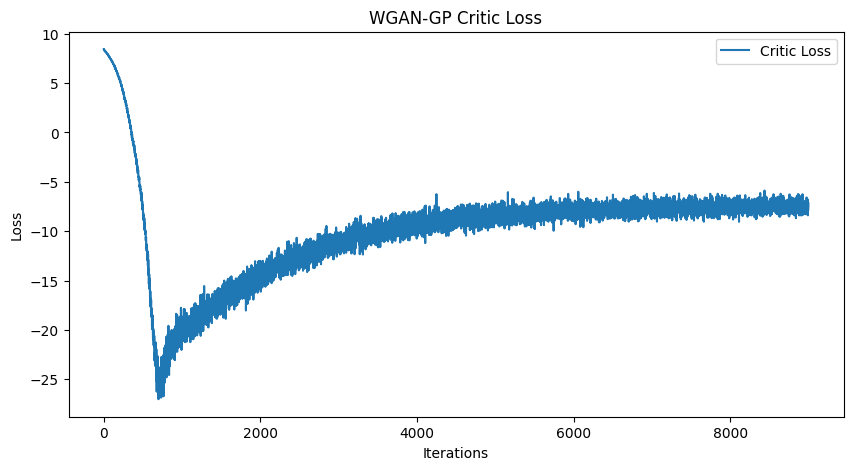

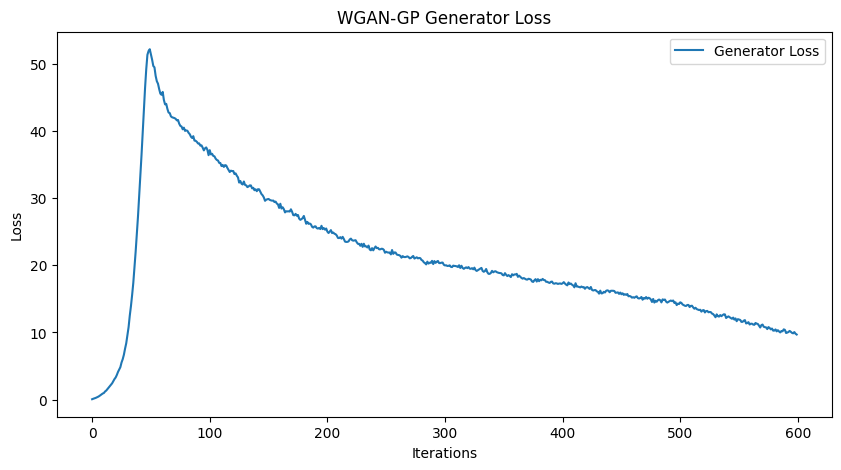

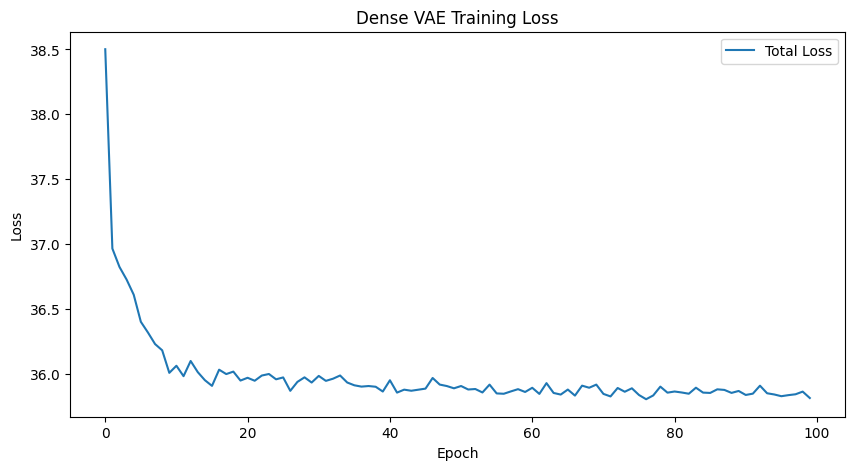

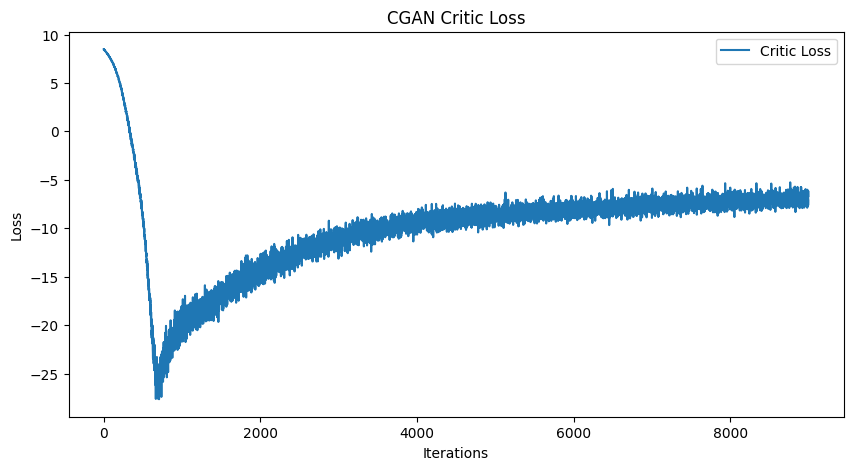

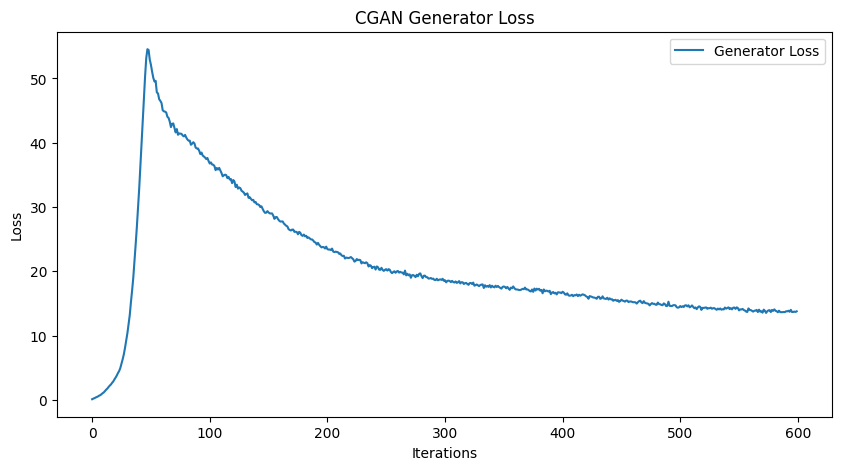

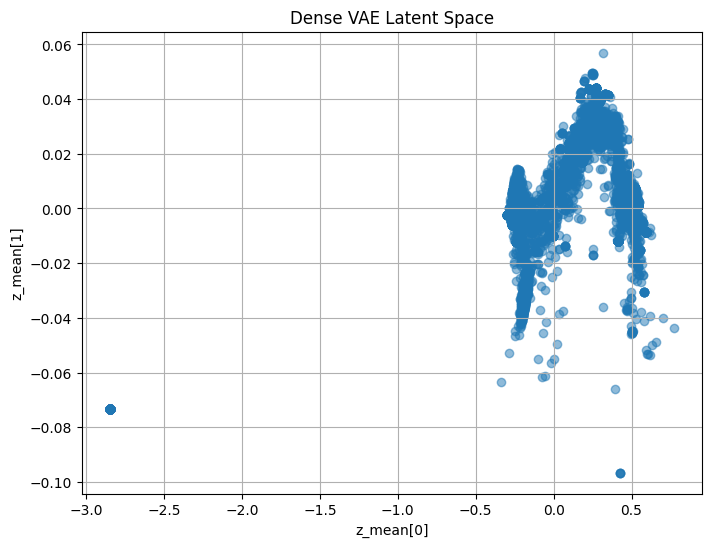

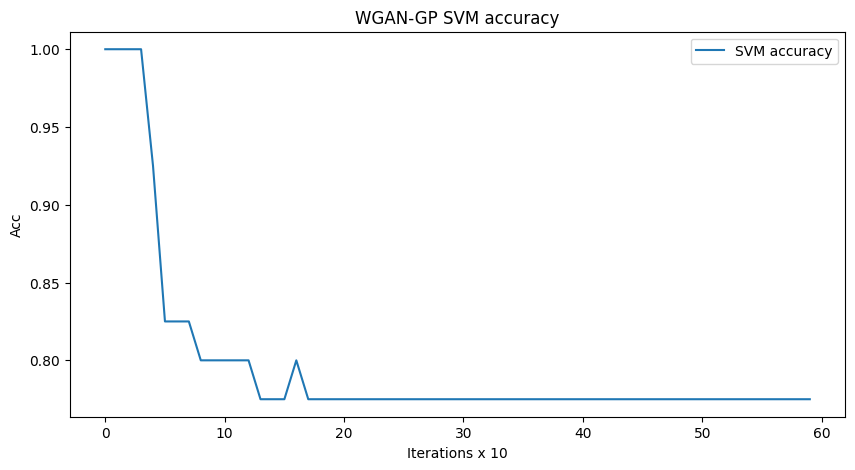

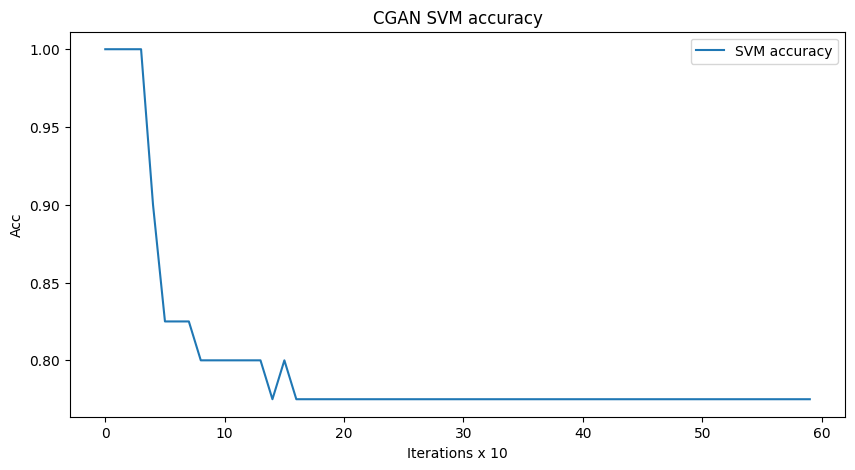

In [13]:
# Plot WGAN-GP Training Losses
plt.figure(figsize=(10, 5))
plt.plot(wgan.critic_losses, label='Critic Loss')
plt.title('WGAN-GP Critic Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot WGAN-GP Training Losses
plt.figure(figsize=(10, 5))
plt.plot(wgan.generator_losses, label='Generator Loss')
plt.title('WGAN-GP Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Dense VAE Training Loss
plt.figure(figsize=(10, 5))
plt.plot(vae_history.history['loss'], label='Total Loss')
plt.title('Dense VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot CGAN Training Losses
plt.figure(figsize=(10, 5))
plt.plot(cgan.critic_losses, label='Critic Loss')
plt.title('CGAN Critic Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot CGAN Training Losses
plt.figure(figsize=(10, 5))
plt.plot(cgan.generator_losses, label='Generator Loss')
plt.title('CGAN Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Dense VAE Latent Space
plt.figure(figsize=(8, 6))
plt.scatter(vae.z_samples[:, 0], vae.z_samples[:, 1], alpha=0.5)
plt.title('Dense VAE Latent Space')
plt.xlabel('z_mean[0]')
plt.ylabel('z_mean[1]')
plt.grid(True)
plt.show()

# Plot WGAN-GP Training Losses
plt.figure(figsize=(10, 5))
plt.plot(wgan.svm_accuracy, label='SVM accuracy')
plt.title('WGAN-GP SVM accuracy')
plt.xlabel('Iterations x 10')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot CGAN Training Losses
plt.figure(figsize=(10, 5))
plt.plot(svm_accuracies, label='SVM accuracy')
plt.title('CGAN SVM accuracy')
plt.xlabel('Iterations x 10')
plt.ylabel('Acc')
plt.legend()
plt.show()

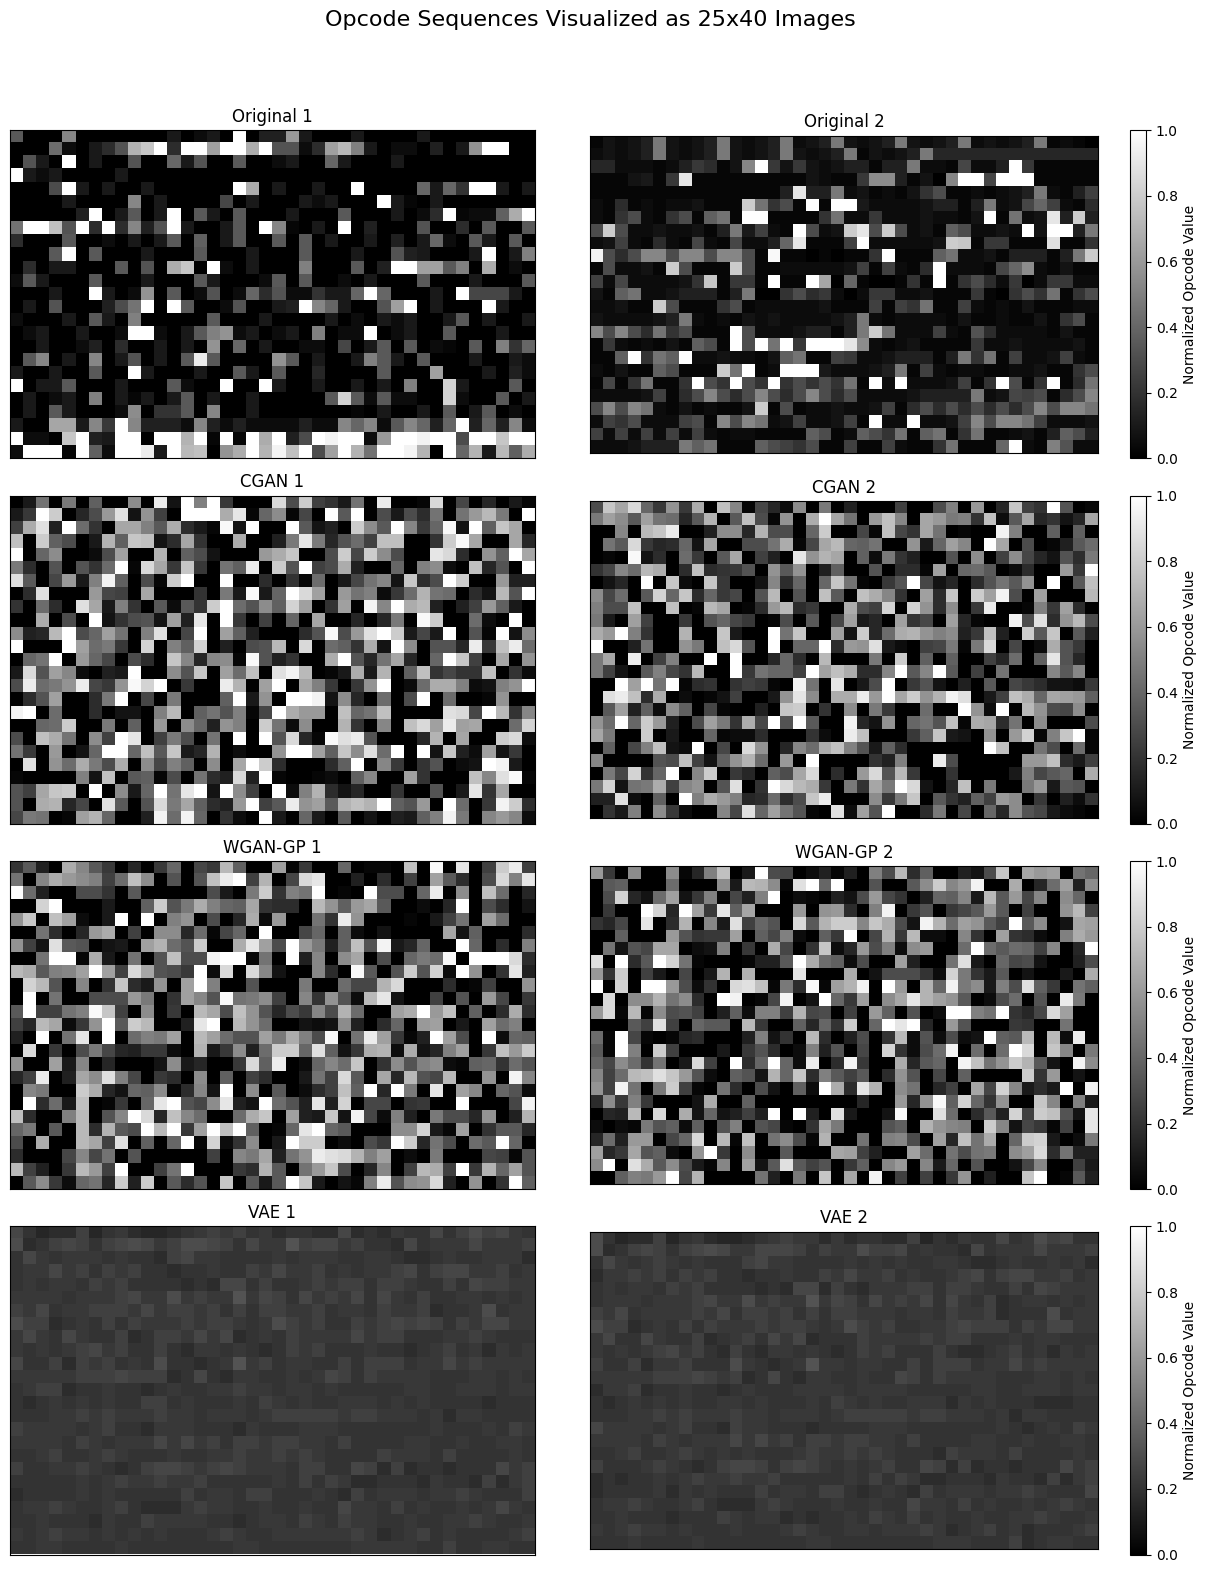

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Verify dataset shapes and values
assert data.shape == (4876, 1000), f"Original data shape mismatch: {data.shape}"
assert synthetic_wgan.shape == (4876, 1000), f"WGAN-GP shape mismatch: {synthetic_wgan.shape}"
assert synthetic_vae.shape == (4876, 1000), f"VAE shape mismatch: {synthetic_vae.shape}"
assert synthetic_cgan.shape == (4876, 1000), f"CGAN shape mismatch: {synthetic_cgan.shape}"

# Check value ranges


# Select 1 random sequence from each dataset
n_samples = 2
datasets = {
    'Original': data,
    'CGAN': synthetic_cgan,
    'WGAN-GP': synthetic_wgan,
    'VAE': synthetic_vae
}
selected_sequences = {}
for name, dataset in datasets.items():
    indices = np.random.choice(dataset.shape[0], n_samples, replace=False)
    selected_sequences[name] = dataset[indices]  # Shape: (5, 1000)

# Plot sequences as 25x40 images
fig, axes = plt.subplots(4, 2, figsize=(13, 16))
fig.suptitle('Opcode Sequences Visualized as 25x40 Images', fontsize=16)

for row_idx, (name, sequences) in enumerate(selected_sequences.items()):
    for col_idx in range(n_samples):
        # Reshape sequence to 25x40 and normalize to [0, 1]
        sequence = sequences[col_idx].reshape(25, 40) / 40.0
        ax = axes[row_idx, col_idx]
        im = ax.imshow(sequence, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'{name} {col_idx + 1}')
        ax.set_xticks([])
        ax.set_yticks([])
        # Add colorbar to the first column of each row
        if col_idx == 1:
            fig.colorbar(im, ax=ax, label='Normalized Opcode Value')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()